## Loading of Steinmetz data

includes some visualizations

In [150]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [151]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [152]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

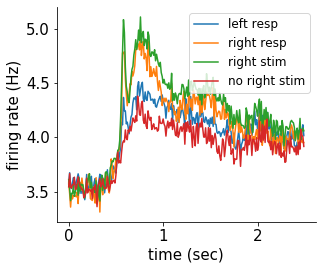

In [153]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

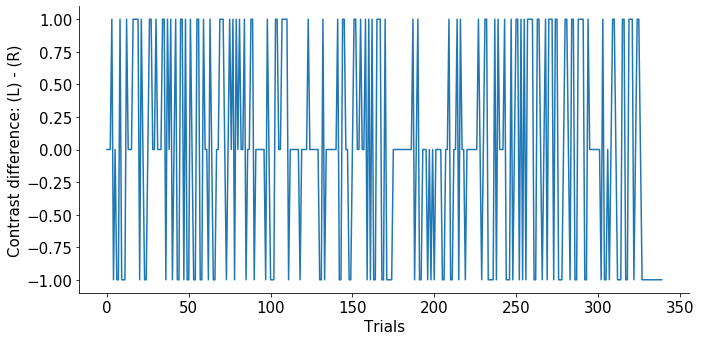

111


In [192]:
#Encode stimulus onset into spike trains using a Poisson GLM

#Make contrast matrix
cL = dat['contrast_left']; cR = dat['contrast_right'];
cdiff = np.empty_like(cL);

for i in range(len(cL)):
    cdiff[i] = 1*(cL[i]>cR[i]) + (-1)*(cL[i] < cR[i]) + 0*(cL[i] == cR[i])

f=plt.figure(figsize=(10,5))
plt.plot(cdiff); plt.xlabel('Trials'); plt.ylabel('Contrast difference: (L) - (R)'); plt.show()
print(np.sum(cdiff<0))

In [193]:
def plot_spikes_with_prediction(
    spikes, predicted_spikes, nt,**kws):
    """ Plot actual and predicted spike counts.

    Args:
    spikes (2D array): Each colum is a vector of actual spike counts, N(trials) x m(fits)
    predicted_spikes (2D array): each column is a vector of predicted spike counts: N(trials) x m(fits)
    nt (number): Number of time bins to plot
    kws: Pass additional keyword arguments to plot()

    """
    f, ax = plt.subplots(1,len(spikes[0]))
    for i in range(len(spikes[0])):
  
      lines = ax[i].stem(spikes[:nt,i], use_line_collection=True)
      plt.setp(lines, color=".5")
      lines[-1].set_zorder(1)
      kws.setdefault("linewidth", 3)
      y2, = ax[i].plot(predicted_spikes[:nt,i], **kws)
      ax[i].set(
          xlabel="Trial number",
          ylabel="Spikes",
      )
      ax[i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
      ax[i].legend([lines[0], y2], ["Spikes", "Predicted"])

      plt.show()

In [178]:
import pdb
from scipy.optimize import minimize
def make_design_matrix(stim,d):
    try:
        padded_stim = np.concatenate([np.zeros(d - 1), stim]);
    except:
        print('Fuck')
        pdb.set_trace()
    T = len(stim)  # Total number of timepoints (hint: total number of stimulus frames)
    X = np.zeros((T, d))
    for t in range(T):
        X[t] = padded_stim[t:t+d];

    return X
    
def neg_log_like(theta,X,y,L1_penalty):
#      Args:
#     theta (1D array): Parameter vector.
#     X (2D array): Full design matrix.
#     y (1D array): Data values. Number of spikes for each trial
    
    rate = np.exp(X @ theta);
    penalty = 20*np.sum((theta)**2); #20*np.sum(np.abs(theta));
    LL = y @ np.log(rate) - np.ones_like(y) @ rate;
    log_lik = LL - penalty;
#     print(f' LL: {LL:1.3f}, L1: {penalty:1.3f}, log_lik: {log_lik:1.3f}')
    return -log_lik;

def fit_lnp(stim,spikes,d,L1_penalty):
    y = spikes
    constant = np.ones_like(y)
    
#     pdb.set_trace();
    X = np.column_stack([constant, make_design_matrix(stim,d)])

    # Use a random vector of weights to start (mean 0, sd .2)
    theta0 = np.random.normal(0, .2, d + 1)

    # Find parameters that minmize the negative log likelihood function
    res = minimize(neg_log_like, theta0, args=(X, y,L1_penalty))

    return res["x"]

def predict_spike_counts_lnp(stim,spikes,d,L1_penalty,theta=None):
    y = spikes
    constant = np.ones_like(spikes)
#     print(theta)
    if theta is None:
        theta = fit_lnp(stim,y,d,L1_penalty)
    
    #Make X again to compute predicted spikes
    X = np.column_stack([constant, make_design_matrix(stim,d)])
    yhat = np.exp(X @ theta);
    return yhat, theta



(340, 698)
OG indices of neurons with min 5 spikes
[  2 100 120 129 141 173 183 184 190 471 496 498 501 523 537 553 562 608
 620 628 631 633 636 637 641 644 657 669]


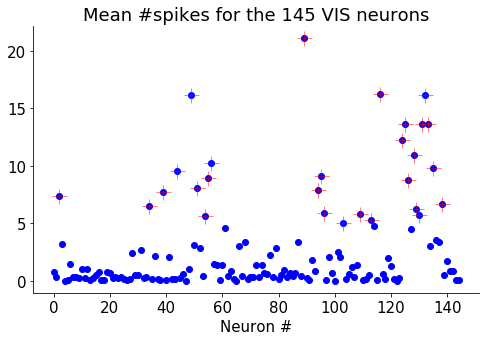

In [194]:
all_spikes = np.transpose(np.sum(dat['spks'][:,:,50:131],axis=2)); print(all_spikes.shape)

#Visualize vis-ctx neurons' firing rates
idx_vis = np.char.startswith(dat['brain_area'],'VIS',start=0,end=None);
vis_neurons = np.where(idx_vis)[0];

#Find neurons with high-ish spike rates and try to encode
vis_spikes = all_spikes[:,vis_neurons]; #print(vis_spikes.shape)
f = plt.figure(figsize=(7,5));
mean_vis_spikes = np.mean(vis_spikes,axis=0);
plt.plot(mean_vis_spikes,'ob'); plt.title(f'Mean #spikes for the {len(vis_neurons):d} VIS neurons');
plt.xlabel('Neuron #')

#Pick neurons with a threshold firing rate/spike number
spike_thresh = 5;
idx_high = np.where(mean_vis_spikes>spike_thresh)[0]; 
vis_neurons_thresh = vis_neurons[idx_high];
print(f'OG indices of neurons with min {spike_thresh:d} spikes'); print(vis_neurons_thresh); # to keep track of which original neuron
plt.plot(idx_high, mean_vis_spikes[idx_high],'+r',markersize=15,alpha=0.5);

plt.savefig('Choice of neuron.png')

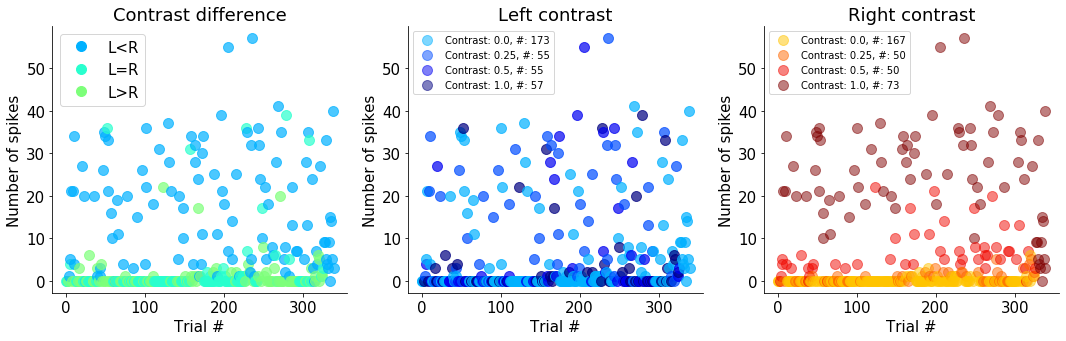

In [264]:
# Work with neuron 
chosen_neuron = 100; # 100 in the list of the whole 698 neurons
spikes_new = all_spikes[:,chosen_neuron]; #print(np.mean(spikes_new))

# Subplot 1: How does #spikes change with contrast difference
color_list = pl.cm.jet(np.linspace(0.3,0.8,6));
f=plt.figure(figsize=(20,5)); 
plt.subplot(1,4,1); 
for i in range(len(cdiff)):
    plt.plot(i,spikes_new[i],'o',color=color_list[int((cdiff[i]+1))],alpha=0.7,markersize=10); 
    
plt.plot(np.inf,np.inf,'o',color=color_list[0],label='L<R',markersize=10); 
plt.plot(np.inf,np.inf,'o',color=color_list[1],label='L=R',markersize=10); 
plt.plot(np.inf,np.inf,'o',color=color_list[2],label='L>R',markersize=10)
plt.legend(loc='upper left'); plt.title('Contrast difference')
plt.xlabel('Trial #'); plt.ylabel('Number of spikes');

# Subplot 2: How does #spikes change with left contrast
color_list = pl.cm.jet(np.linspace(0.3,0,4));
plt.subplot(1,4,2); 
contrast_list = np.unique(cL); 
for itrial in range(len(cL)):
    idx = np.where(contrast_list == cL[itrial])[0][0];
    plt.plot(itrial, spikes_new[itrial],'o',color=color_list[idx],alpha=0.7,markersize=10); 

for i in range(len(contrast_list)):
    plt.plot(np.inf,np.inf,'o',color=color_list[i],alpha=0.5,markersize=10,label=f'Contrast: {contrast_list[i]}, #: {np.sum(cL == contrast_list[i]):d}');

plt.legend(fontsize=10); plt.xlabel('Trial #'); plt.ylabel('Number of spikes')
plt.title('Left contrast')
  
    
# #Subplot 3: How does #spikes change with right contrast
color_list = pl.cm.jet(np.linspace(0.7,1,4));
plt.subplot(1,4,3); 
contrast_list = np.unique(cR); 
for itrial in range(len(cR)):
    idx = np.where(contrast_list == cR[itrial])[0][0];
    plt.plot(itrial, spikes_new[itrial],'o',color=color_list[idx],alpha=0.5,markersize=10); 

for i in range(len(contrast_list)):
    plt.plot(np.inf,np.inf,'o',color=color_list[i],alpha=0.5,markersize=10,label=f'Contrast: {contrast_list[i]}, #: {np.sum(cR == contrast_list[i]):d}');

plt.legend(fontsize=10); plt.xlabel('Trial #'); plt.ylabel('Number of spikes')
plt.title('Right contrast')
  
plt.savefig('Choice_of_stimulus.png')

In [262]:
np.linspace(0.3,0,4)

array([0.3, 0.2, 0.1, 0. ])

In [291]:
'''
1. Divide data into train-test. Preserve chronology!
2. Encode 
    (a) contrast difference, 
    (b) right contrast in Poisson GLM on train data
3. Test accuracy on test data.
    (a) MSE
    (b) R^2

'''
# Initialise variables for Poisson GLM fitting
L1_penalty = 1;

# Define types of stimuli
stim_type =['Contrast difference','Left contrast','Right contrast'];

# Get index of train and test data
idx_train = range(0,int(len(cdiff)*0.75)); idx_test = range(int(len(cdiff)*0.75), len(cdiff)); 

# Divide stimuli into train and test 
stim_train = np.empty(shape=(len(idx_train),len(stim_type))); 
stim_test = np.empty(shape=(len(idx_test),len(stim_type)));

stim_train[:,0] = cdiff[idx_train]; stim_test[:,0] = cdiff[idx_test]; # Stimulus 1: Contrast difference
stim_train[:,1] = cL[idx_train]; stim_test[:,1] = cL[idx_test];# Stimulus 2: Right contrast
stim_train[:,2] = cR[idx_train]; stim_test[:,2] = cR[idx_test];# Stimulus 2: Right contrast

# Divide spikes into train and test
spikes_train = all_spikes[idx_train,:]; spikes_train = spikes_train[:, vis_neurons_thresh]; 
spikes_test = all_spikes[idx_test,:]; spikes_test = spikes_test[:, vis_neurons_thresh]; 

# List d parameters
d_list = range(2,30,2); 

# Initialize variable for each L1 penalty
ytrain = np.empty(shape=(len(idx_train),len(stim_type),len(d_list),len(vis_neurons_thresh)));
ytest = np.empty(shape=(len(idx_test),len(stim_type),len(d_list),len(vis_neurons_thresh)));
train_accuracy, test_accuracy = [np.empty(shape=(len(stim_type),len(d_list),len(vis_neurons_thresh))) for _ in range(2)];

# Initialize theta_d to store temporal filters for d=10 values
theta_d = np.empty(shape=(11,len(stim_type),len(vis_neurons_thresh)))

# Fit to training data and evaluate on test data
for chosen_neuron in range(len(vis_neurons_thresh)):
    print(vis_neurons_thresh[chosen_neuron])
    for d1 in range(len(d_list)):
        for istim in range(len(stim_type)):
            ytrain[:,istim,d1,chosen_neuron], theta = predict_spike_counts_lnp(
                stim_train[:,istim], spikes_train[:,chosen_neuron],d_list[d1],L1_penalty);
            ytest[:,istim,d1,chosen_neuron],_ = predict_spike_counts_lnp(
                stim_test[:,istim],spikes_test[:,chosen_neuron],d_list[d1],L1_penalty,theta);

            # Evaluate 'accuracy' on train and test data
            train_accuracy[istim,d1,chosen_neuron] = np.mean(
                np.divide(((ytrain[:,istim,d1,chosen_neuron] - spikes_train[:,chosen_neuron])**2), ytrain[:,istim,d1,chosen_neuron])
            );
            test_accuracy[istim,d1,chosen_neuron] = np.mean(
                np.divide(((ytest[:,istim,d1,chosen_neuron] - spikes_test[:,chosen_neuron])**2), ytest[:,istim,d1,chosen_neuron])
            );
            
           #save theta for d=10
            if d_list[d1]==10:
                theta_d[:,istim,chosen_neuron] = theta;  



2
100
120
129
141
173


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


183
184
190


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


471


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


496


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


498
501
523
537
553
562
608
620


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


628
631
633
636
637
641


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


644
657
669


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


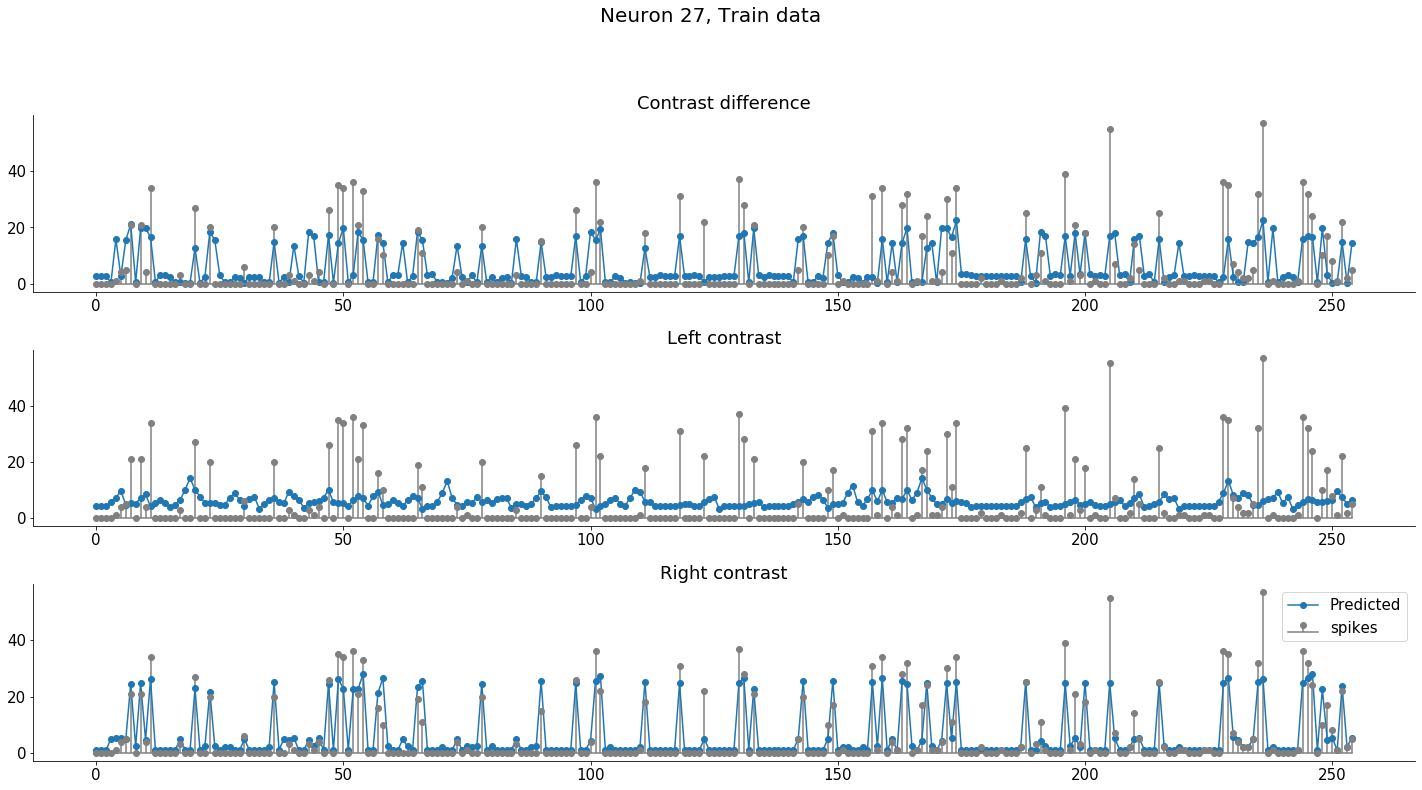

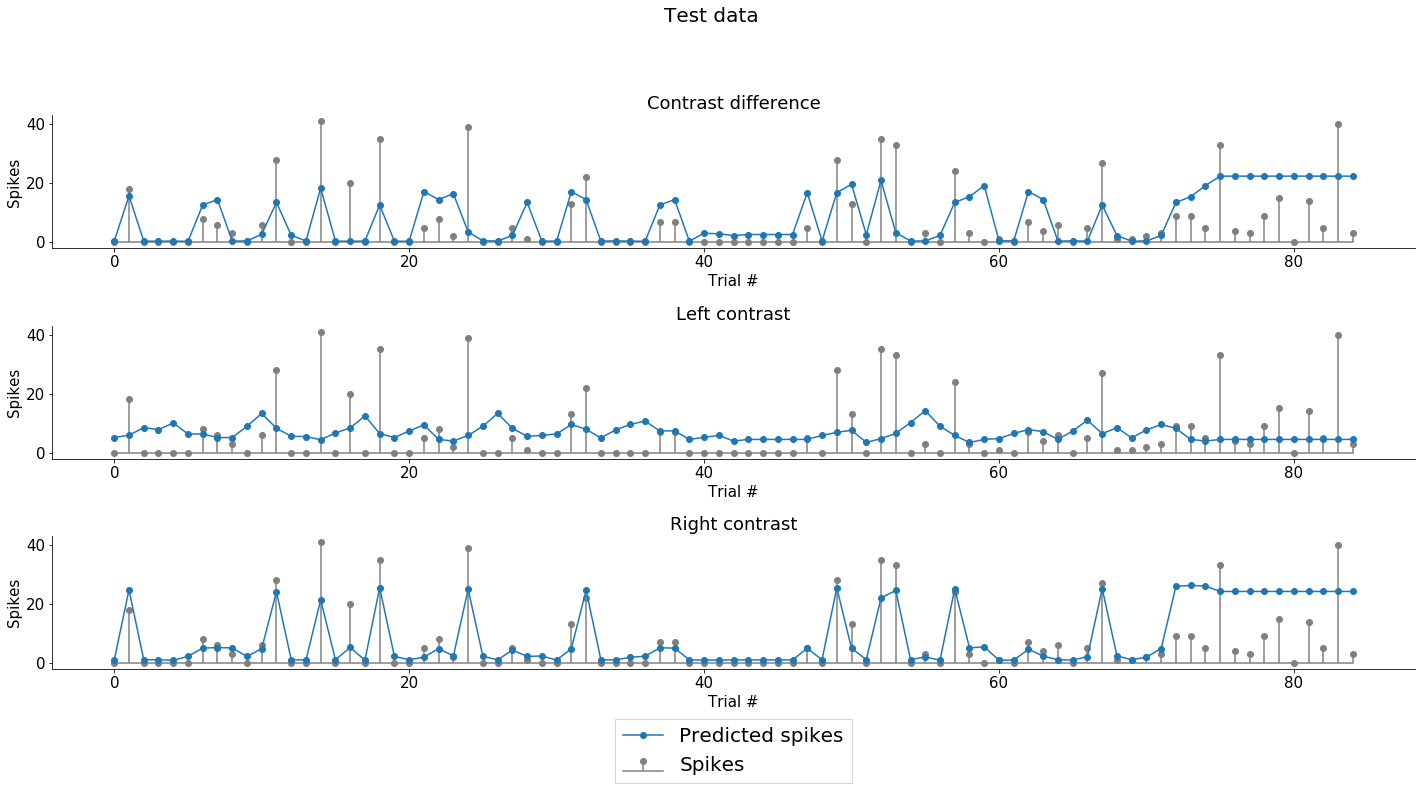

In [302]:
# Plot train data for d = 20 and a good neuron (100)
whichd=1; which_neuron = 1;
f=plt.figure(figsize=(20,10))
for istim in range(len(stim_type)):
        plt.subplot(len(stim_type),1,istim+1); plt.plot(ytrain[:,istim,whichd,which_neuron],'o-',label='Predicted'); plt.title(stim_type[istim]);
        markerline, stemlines, baseline = plt.stem(spikes_train[:,which_neuron],linefmt='grey',basefmt='grey',label='spikes', use_line_collection=True); 
        markerline.set_markerfacecolor('grey'); 
        plt.setp(markerline,color="0.5")

plt.suptitle(f'Neuron {chosen_neuron:d}, Train data', y=1.1, fontsize=20)    
plt.legend();
plt.savefig('Train data.png')
plt.show();

# Plot test data 
f=plt.figure(figsize=(20,10))
for istim in range(len(stim_type)):
    plt.subplot(len(stim_type),1,istim+1); 
    markerline, stemlines, baseline = plt.stem(spikes_test[:,which_neuron],linefmt='grey',basefmt='grey',use_line_collection=True,label='Spikes'); 
    markerline.set_markerfacecolor('grey'); plt.setp(markerline,color="0.5");
    plt.plot(ytest[:,istim,whichd,which_neuron],'o-',label='Predicted spikes'); 
    plt.title(stim_type[istim]); plt.xlabel('Trial #'); plt.ylabel('Spikes')
    
plt.suptitle('Test data', y=1.1, fontsize=20); 
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.3),fancybox=False, shadow=False,prop={'size':20})

# plt.legend(bbox_to_anchor=(0, 1), loc='upper left',prop={'size': 20});

plt.savefig('Test data.png')
plt.show();


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


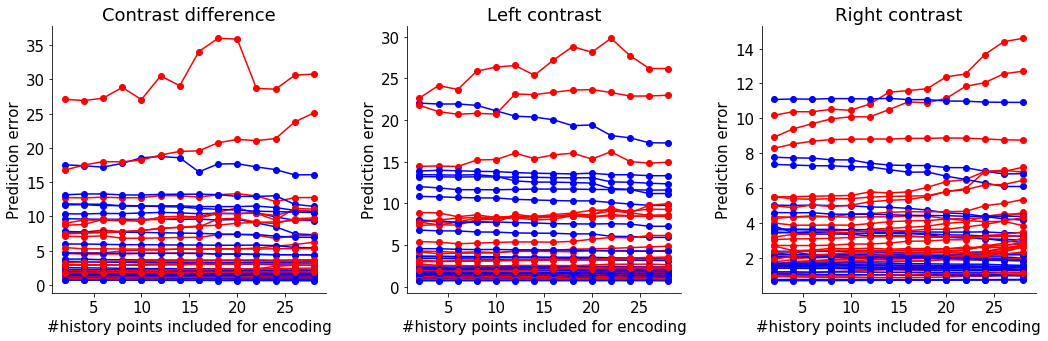

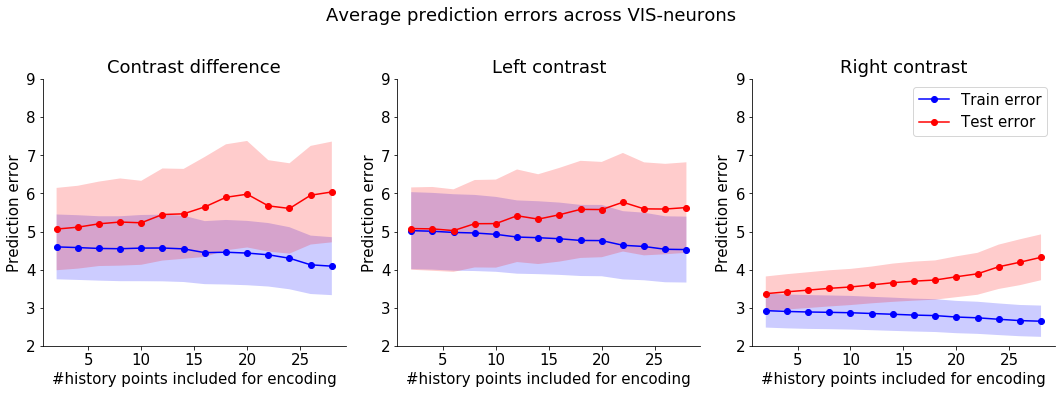

In [293]:
# Plot train-test accuracy for each neuron
f=plt.figure(figsize=(15,5));
for istim in range(len(stim_type)):
    for which_neuron in range(len(vis_neurons_thresh)):
        plt.subplot(1,len(stim_type),istim+1); plt.plot(d_list, train_accuracy[istim,:,which_neuron],'o-b',label='Train accuracy'); 
        plt.plot(d_list,test_accuracy[istim,:,which_neuron],'o-r',label='Test accuracy');
        plt.title(stim_type[istim]); plt.xlabel('#history points included for encoding'); plt.ylabel('Prediction error');
 
plt.show();

# Plot average train-test accuracy
f=plt.figure(figsize=(15,5));
for istim in range(len(stim_type)):
    
    yy_train = np.mean(train_accuracy[istim,:,:],axis=1);
    yy_test = np.mean(test_accuracy[istim,:,:],axis=1);
    err_train = np.std(train_accuracy[istim,:,:],axis=1)/np.sqrt(len(train_accuracy[istim,0,]));
    err_test = np.std(test_accuracy[istim,:,:],axis=1)/np.sqrt(len(test_accuracy[istim,0,]));
    
    plt.subplot(1,len(stim_type),istim+1); plt.plot(d_list,yy_train,'o-b',label='Train error');
    plt.plot(d_list,yy_test,'o-r',label='Test error');
    plt.fill_between(d_list,yy_train-err_train,yy_train+err_train,facecolor='b',alpha=0.2);
    plt.fill_between(d_list,yy_test-err_test,yy_test+err_test,facecolor='r',alpha=0.2);
    
    plt.ylim([2,9])
    plt.title(stim_type[istim]); plt.xlabel('#history points included for encoding'); plt.ylabel('Prediction error')

plt.suptitle('Average prediction errors across VIS-neurons',y=1.1);
plt.legend();
plt.savefig('Test-train accuracy.png');
plt.show();


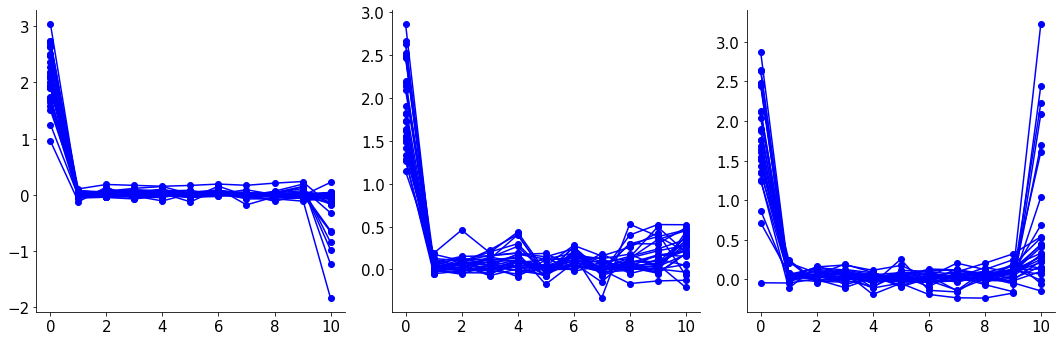

In [298]:
# plot temporal filters 

f=plt.figure(figsize=(15,5));
for istim in range(len(stim_type)):
    plt.subplot(1,len(stim_type),istim+1);
    for chosen_neuron in range(len(vis_neurons_thresh)):
        plt.plot(theta_d[:,istim,chosen_neuron],'-ob');

In [170]:
all_spikes[idx_train,vis_neurons_thresh]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (255,) (28,) 

## Run dimension reduction and decoding decisions

## Dimension Reduction

In [27]:
# prepare input data

all_spikes = dat['spks']
print('neurons, trials, time_bins: ', all_spikes.shape)
# neurons, trials, time_bins
NN = all_spikes.shape[0] # number of neurons
N_trials = all_spikes.shape[1] # number of trials
N_time = all_spikes.shape[2] # number of time_bins



neurons, trials, time_bins:  (698, 340, 250)


In [28]:

go_cues = dat['gocue']
print('go_cues: ', go_cues.shape)

response_times = dat['response_time']
print('response_times: ', response_times.shape)

# get the max time length
stim_onset = 51
max_len = int(np.ceil(100*np.max(go_cues))) + stim_onset
print(max_len)

data = np.reshape(all_spikes[:,:,stim_onset:max_len], (NN, -1)).T 
print(data.shape)


go_cues:  (340, 1)
response_times:  (340, 1)
131
(27200, 698)


### DR - ICA

In [29]:
# use ICA 

from sklearn.decomposition import FastICA

transformer = FastICA(n_components=3, random_state=0)
X_transformed = transformer.fit_transform(data)
print(X_transformed.shape)


(27200, 3)


## Decoding decision

In [30]:
# prepare the y labels for the x input

choice_responses = dat['response']
print(choice_responses.shape)

print('left trials: ', len(np.where(choice_responses < 0)[0]))
print('right trials: ', len(np.where(choice_responses > 0)[0]))
print('no response trials: ', len(np.where(choice_responses == 0)[0]))

idxs = np.where(choice_responses < 0)[0]
idxs = np.append(idxs, np.where(choice_responses > 0)[0])

Y = choice_responses[idxs]
print(Y.shape)


(340,)
left trials:  141
right trials:  135
no response trials:  64
(276,)


## Linear Discriminant Analysis


[1.]
0.875


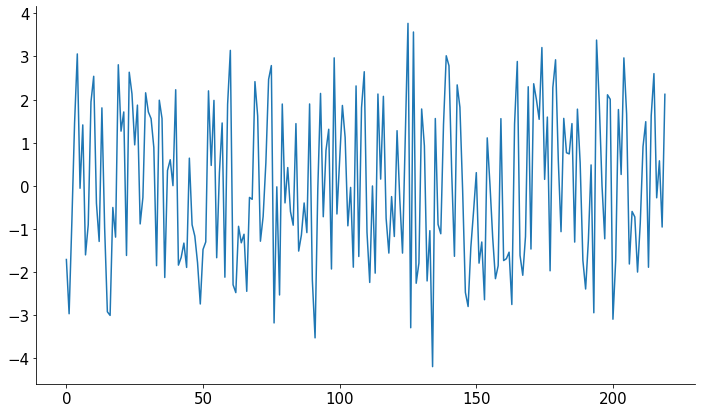

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# gocue = (np.ceil((dat['gocue']*100)))
# end_bin = np.int(np.max(gocue))

# spike_data = np.reshape(dat['spks'][:,idxs,51:51+end_bin], (NN,-1))  #shape is neurons by time and trials
# spike_data = spike_data - np.mean(spike_data, axis=1)[:,np.newaxis]  #subtract mean

# choices = np.repeat(dat['response'][idxs,], end_bin)

# # split into training and test
# X_train, X_test, y_train, y_test = train_test_split(spike_data.T, choices, test_size=0.3, random_state=0)


model = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)

input_X = np.swapaxes(all_spikes, 0, 1)
input_X = np.reshape(np.mean(input_X[:,:,stim_onset:max_len], axis=2), (N_trials, -1)) 

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(input_X[idxs], Y, test_size=0.2, random_state=0)


X_transform_LDA = model.fit_transform(X_train,y_train)
print(model.explained_variance_ratio_)
print(model.score(X_test,y_test))
plt.figure(figsize= (10, 6))
plt.plot(X_transform_LDA)


## Naive Bayes Classifier

In [11]:
# use Bernoulli naive bayes to classify 

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()


X = X_transformed.reshape((N_trials, -1))[idxs]

clf.fit(X, Y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [43]:
print(X.shape)
print(N_trials)

(276, 240)
340


## Cross-validation and evaluation

In [12]:
from sklearn.model_selection import cross_validate 

scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)

print(scores)
score = np.mean(scores['test_score'])
print(score)


{'fit_time': array([0.00300336, 0.00297499, 0.00194168]), 'score_time': array([0.00112605, 0.00142193, 0.00105572]), 'test_score': array([0.51086957, 0.58695652, 0.58695652]), 'train_score': array([0.77717391, 0.85869565, 0.79891304])}
0.5615942028985508


### Find the optimal number of reduced components

In [31]:
# find the optimal number of reduced components

components = [range(20), 200, 400]
cv = 5

val_scores = []
# do dim reduction
for comp in components:
  transformer = FastICA(n_components=comp, random_state=0)
  X_transformed = transformer.fit_transform(data)
  print('dim reduced X: ', X_transformed.shape)

  X = X_transformed.reshape((N_trials, -1))[idxs]
  # Y = choice_responses[idxs]

  # cross validate
  scores = cross_validate(clf, X, Y, cv=cv)
  score = np.mean(scores['test_score'])
  val_scores.append(score)

print('scores: ', val_scores)


TypeError: '>' not supported between instances of 'range' and 'int'

Text(0.5, 1.0, 'scores vs. ICA N_components')

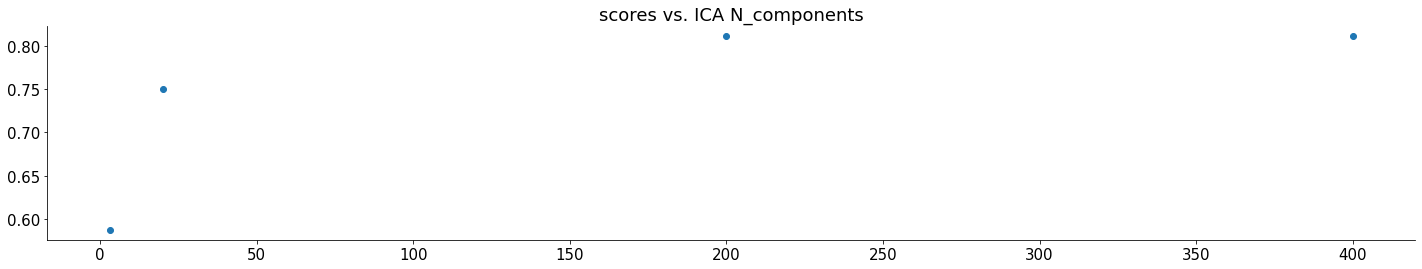

In [14]:
# plotting the scores vs components

plt.plot(components, val_scores, 'o')
plt.title('scores vs. ICA N_components')

Dimensionality reduction - GPFA (data imported from MATLAB)


In [13]:
#Tanvi - 10 AM EST Jun 22
import scipy.io as sio
print(np.size(alldat))

for isession in range(len(alldat)):
    dd = alldat[isession]
    Y=np.transpose(dd['spks'],(1,0,2)); print(Y.shape)
    sio.savemat(f'/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/Py2MATLAB_forGPFA/Py2MATLAB_forGPFA_{isession:d}.mat',{'Y':Y});
print('done');

39
(214, 734, 250)
(251, 1070, 250)
(228, 619, 250)
(249, 1769, 250)
(254, 1077, 250)
(290, 1169, 250)
(252, 584, 250)
(250, 1156, 250)
(372, 788, 250)
(447, 1172, 250)
(342, 857, 250)
(340, 698, 250)
(300, 983, 250)
(268, 756, 250)
(404, 743, 250)
(280, 474, 250)
(224, 565, 250)
(316, 1089, 250)
(247, 606, 250)
(235, 899, 250)
(124, 578, 250)
(444, 646, 250)
(151, 1268, 250)
(187, 1337, 250)
(261, 885, 250)
(178, 1056, 250)
(253, 563, 250)
(142, 549, 250)
(128, 750, 250)
(143, 942, 250)
(237, 977, 250)
(260, 522, 250)
(191, 613, 250)
(296, 781, 250)
(311, 795, 250)
(258, 680, 250)
(181, 1055, 250)
(199, 805, 250)
(343, 1348, 250)
done


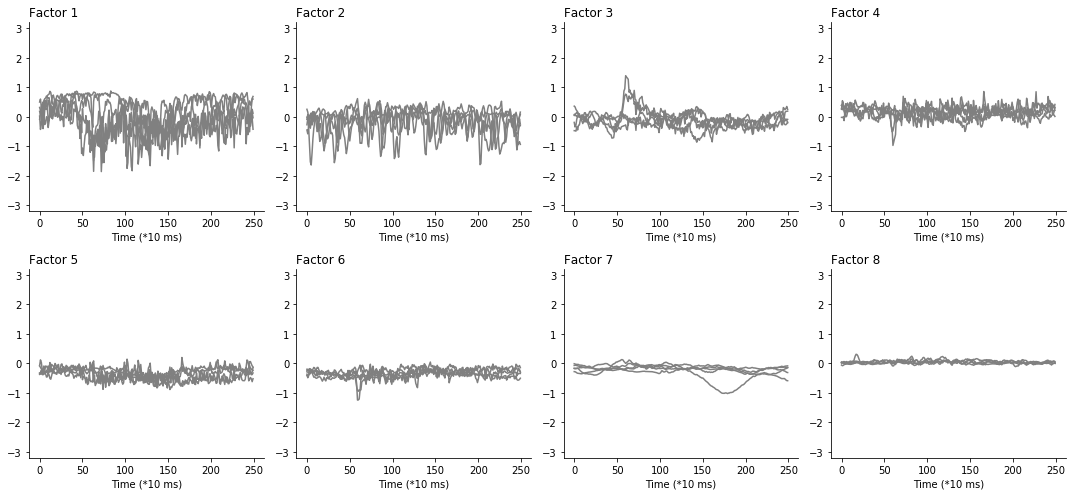

In [309]:
%matplotlib inline
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

gpfa_Y = loadmat('/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/gpfa_v0203/GPFA_reduced.mat')['gpfa_Y'];
#gpfa_Y = loadmat('GPFA_reduced.mat')['gpfa_Y']; # Use this for google colab

xx=np.squeeze(gpfa_Y[0:2]).shape; 

f=plt.figure(figsize=(15,7))
for ifa in range(8):
  plt.subplot(2,4,ifa+1), 
  for it in range(5):
    plt.plot(gpfa_Y[it][ifa],'grey'); 
  plt.ylim([-3.2,3.2]); plt.xlabel('Time (*10 ms)');
  plt.title('Factor %i' %(ifa+1),loc='left')
# plt.suptitle('Factors from 8-dim GPFA reduction',fontsize=15);
plt.savefig('gpfa_viz_session_11.jpg')
plt.show()

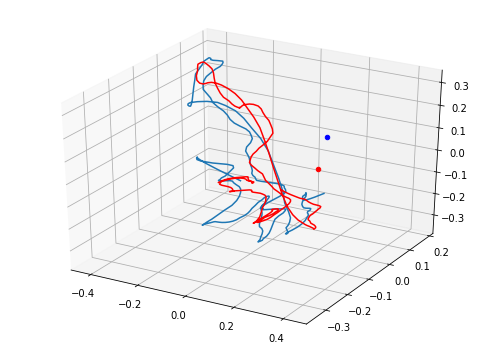

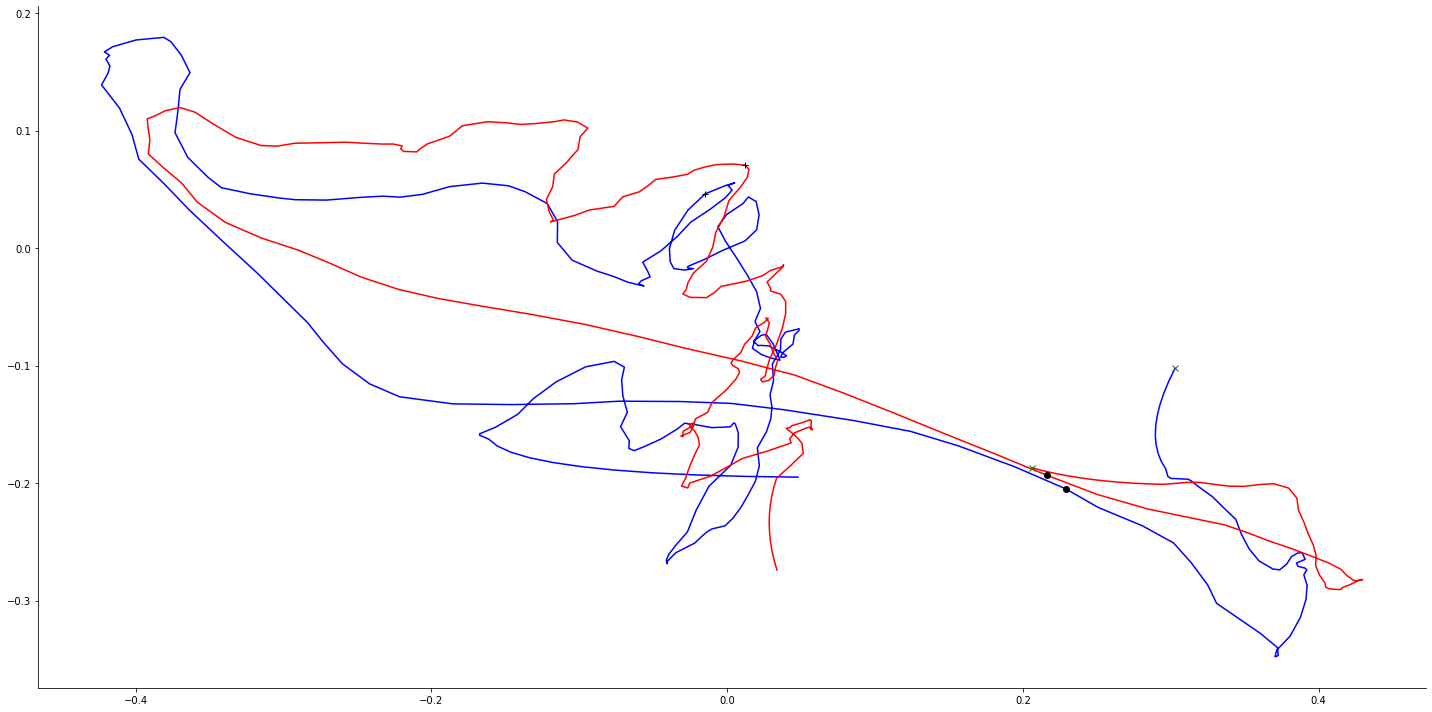

In [310]:
%matplotlib inline
from scipy.signal import savgol_filter

Y=dat['response']; 
gy1 = savgol_filter(np.mean(gpfa_Y[np.where(Y==-1)],axis=0),21,2); 
gy2 = savgol_filter(np.mean(gpfa_Y[np.where(Y==1)],axis=0),21,2); 

f = plt.figure(figsize=(7,5)); ax2 = f.add_subplot(111, projection='3d')
ax2.plot3D(gy1[0],gy1[1],gy1[2]); ax2.plot3D(gy2[0],gy2[1],gy2[2],color='red');
ax2.scatter3D(gy1[0][0],gy1[1][0],gy1[2][0],'x',color='blue'); ax2.scatter3D(gy2[0][0],gy2[1][0],gy2[2][0],'x',color='red'); 

f=plt.figure(figsize=(20,10))
plt.plot(gy1[0],gy1[1],color='blue'); plt.plot(gy2[0],gy2[1],color='red'); 
plt.plot(gy1[0][0],gy1[1][0],'x',color='green');plt.plot(gy2[0][0],gy2[1][0],'x',color='green');
plt.plot(gy1[0][51],gy1[1][51],'o',color='black');plt.plot(gy2[0][51],gy2[1][51],'o',color='black')
plt.plot(gy1[0][131],gy1[1][131],'+',color='black');plt.plot(gy2[0][131],gy2[1][131],'+',color='black')

In [43]:
gy1[0][0]


0.25969015533847156

Classification of GPFA reduced data using Naive Bayes classifier

In [238]:
'''
TO DO: Plot GPFA weights corresponding to each individual brain area across ALL sessions

(A) Gather weights from all sessions
(B) Gather brain_area from all sessions
(C) Plot mean weights by brain_areas (next cell)
(D) Plot mean weights by bigger brain groups (cell after next)

'''
from scipy.io import loadmat
from tqdm import tqdm
import numpy.matlib as npm
# determine weights (neurons to latent_state) from GPFA and what brain regions they correspond to

C_all_tmp = np.empty(shape=(100000,8),dtype=object); 
reduced_Y_tmp = np.empty(shape=(100000,8,25),dtype=object);

brain_area_tmp, choice_all_tmp = [np.empty(shape=(100000), dtype=object) for _ in range(2)];
direc = '/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/MATLAB2Py_afterGPFA/';

idx_start = 0; idx_startY = 0;
for isession in tqdm(range(39)):
    fname = direc + 'GPFA_red_' + str(isession+1)+'.mat'; # Files from MATLAB are just returned with one index misplaced
    try:
        C = loadmat(fname)['C']; 
        reduced_Y = loadmat(fname)['gpfa_Y']; 
        n_neuron = len(C); n_trials = len(reduced_Y); 
        C_all_tmp[idx_start:(idx_start+n_neuron),:] = C; 
        reduced_Y_tmp[idx_startY:(idx_startY+n_trials),:,:] = reduced_Y; 
        
        dat = alldat[isession]; 
        brain_area_tmp[idx_start:(idx_start+n_neuron)] = dat['brain_area'][0:n_neuron]; 
        choice_all_tmp[idx_startY:(idx_startY+n_trials)] = dat['response'][0:n_trials];
        
        idx_start = idx_start + n_neuron;
        idx_startY = idx_startY + n_trials;
    except:
        print(fname + ' not found');
#         pdb.set_trace();

C_all = C_all_tmp[0:idx_start,:]; 
brain_area_all = brain_area_tmp[0:idx_start];

reduced_Y_all = reduced_Y_tmp[0:idx_startY,:,:];
choice_all = choice_all_tmp[0:idx_startY];

print('----- All weights from GPFA: C[n_neuron x 8 ] -----')
print(C_all.shape); 


 72%|███████▏  | 28/39 [00:00<00:00, 36.03it/s]

/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/MATLAB2Py_afterGPFA/GPFA_red_23.mat not found
/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/MATLAB2Py_afterGPFA/GPFA_red_24.mat not found
/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/MATLAB2Py_afterGPFA/GPFA_red_29.mat not found


100%|██████████| 39/39 [00:01<00:00, 35.36it/s]


/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/MATLAB2Py_afterGPFA/GPFA_red_39.mat not found
----- All weights from GPFA: C[n_neuron x 8 ] -----
(29061, 8)


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


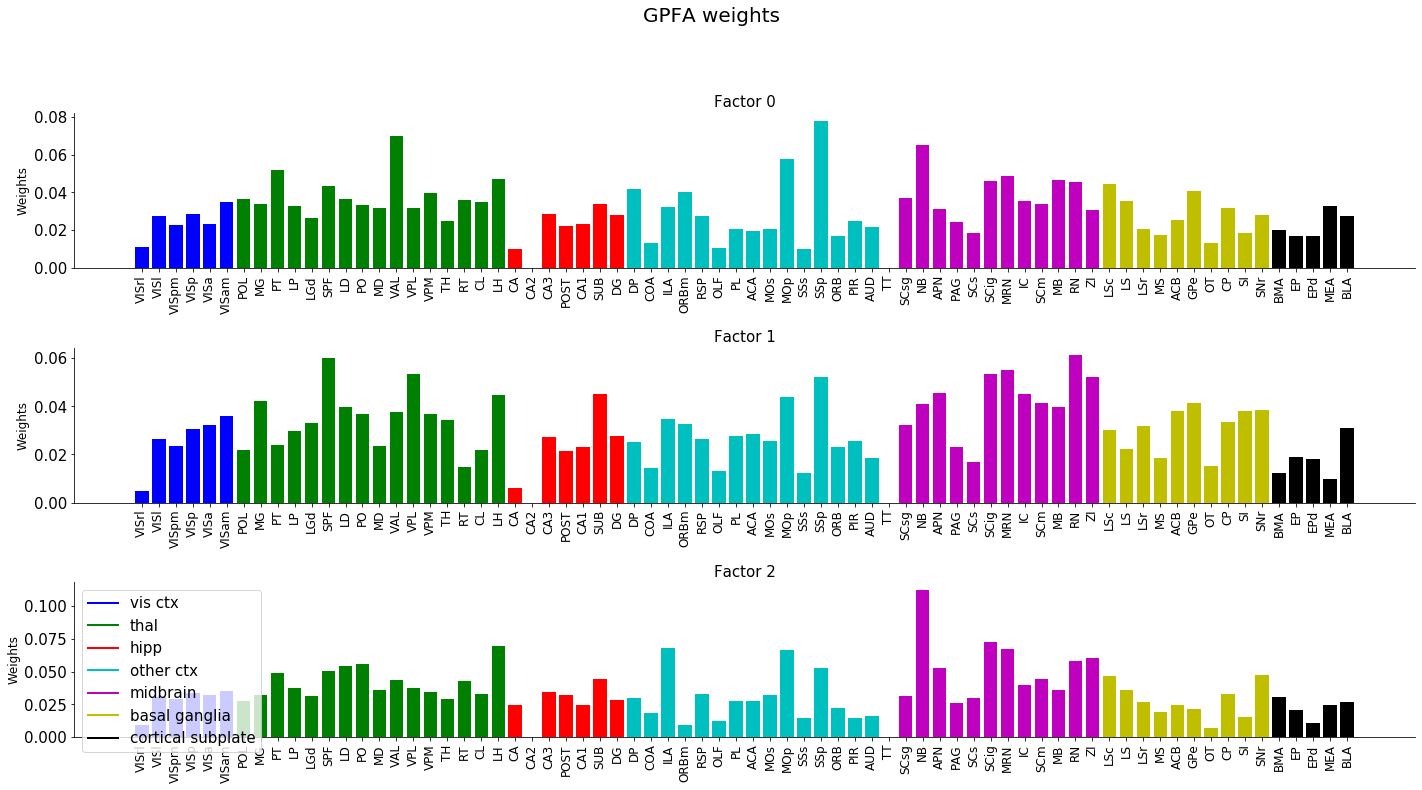

In [278]:
'''
TO DO: Plot GPFA weights corresponding to each individual brain area across ALL sessions

(C): Plot mean weights: sorted by ICA grouping (import this from Jun's part of the code) 

'''
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]

sorted_brain_groups = [ ['VISrl', 'VISl', 'VISpm', 'VISp', 'VISa', 'VISam'],
['POL', 'MG', 'PT', 'LP', 'LGd', 'SPF', 'LD', 'PO', 'MD', 'VAL', 'VPL', 'VPM', 'TH','RT', 'CL', 'LH'],
['CA', 'CA2', 'CA3', 'POST', 'CA1', 'SUB', 'DG'],
['DP', 'COA', 'ILA', 'ORBm', 'RSP', 'OLF', 'PL', 'ACA', 'MOs', 'MOp', 'SSs', 'SSp','ORB', 'PIR', 'AUD', ' TT'],
['SCsg', 'NB', 'APN', 'PAG', 'SCs', 'SCig', 'MRN', 'IC', 'SCm', 'MB', 'RN', 'ZI'],
['LSc', 'LS', 'LSr', 'MS', 'ACB', 'GPe', 'OT', 'CP', 'SI', 'SNr'],
['BMA', 'EP', 'EPd', 'MEA', 'BLA'] ]


all_brain_groups = []; all_area = [];
for sublist in range(len(sorted_brain_groups)):
    for item in range(len(sorted_brain_groups[sublist])):
        all_brain_groups.append(sorted_brain_groups[sublist][item])
        all_area.append(sublist);

        
# col_list = ['blue','green','red','cyan','magenta','yellow','black']
col_list=['b', 'g', 'r', 'c', 'm', 'y', 'k']
which_color=1;
f = plt.figure(figsize=(20,10));
for ifa in range(3):
    for ib in range(len(all_brain_groups)):
        which_color=all_area[ib]
        plt.subplot(3,1,ifa+1); 
        
        idx_by_brain=brain_area_all == all_brain_groups[ib]; 
        
        try:
            if np.sum(idx_by_brain)==0:
                yy=0;
            else:
                yy=np.mean(np.abs(C_all[idx_by_brain,ifa]));
        except:
            pdb.set_trace();
                
        plt.bar(ib, yy,color=col_list[which_color])
        plt.xticks(range(len(all_brain_groups)),all_brain_groups,rotation='vertical',fontsize=12);
        plt.title(f"Factor {ifa:d}", fontsize=15); plt.ylabel('Weights',fontsize=12);

for icol in range(len(col_list)):
    plt.plot(np.inf,np.inf,color=col_list[icol],linewidth=2,label=regions[icol]);
    plt.legend(loc='upper left');
plt.suptitle('GPFA weights',y=1.1,fontsize=20)
plt.savefig('GPFA weights_smallbrain');
plt.show();



(29061,)


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


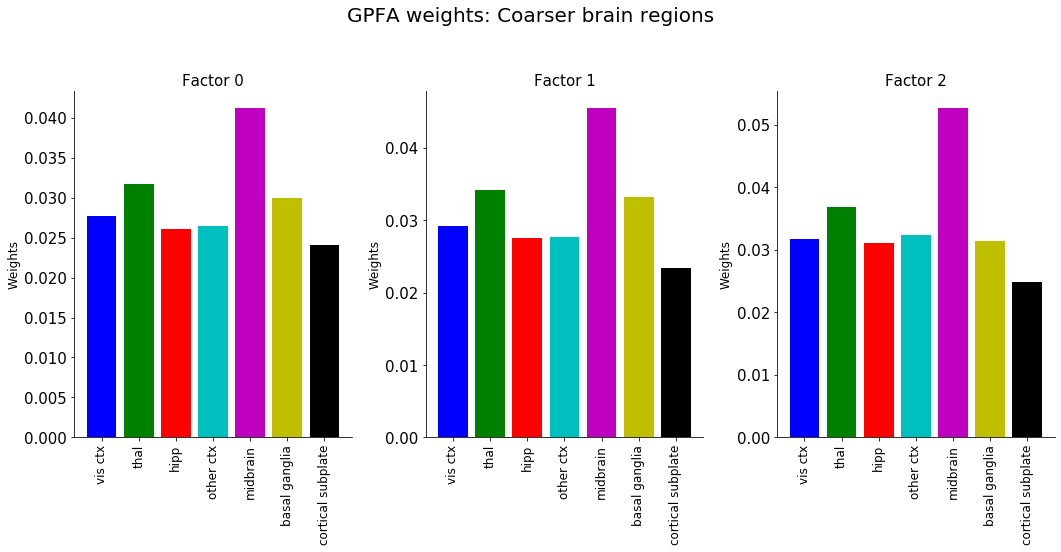

In [279]:
'''
TO DO:

(D) Plot mean weights by bigger brain groups (cell after next)
'''
nareas = len(regions)-1 
NN = len(brain_area_all) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(brain_area_all, sorted_brain_groups[j])] = j # assign a number to each region

print(barea.shape)
f=plt.figure(figsize=(15,7));

for ifa in range(3):
    for j in range(nareas):
        plt.subplot(1,3,ifa+1); 
        
        try:
            yy = np.mean(np.abs(C_all[barea==j,ifa]));
            plt.bar(j,yy, color=col_list[j],label=regions[j]);
            plt.title(f"Factor {ifa:d}", fontsize=15); plt.ylabel('Weights',fontsize=12);
        except:
            pdb.set_trace();
            
    plt.xticks(range(len(regions)-1),regions[:-1],rotation='vertical',fontsize=12);

plt.suptitle('GPFA weights: Coarser brain regions',y=1.1,fontsize=20);
plt.savefig('GPFA weights_bigbrain')
plt.show()

In [ ]:
# Only for presentation:


In [249]:
# Find non no-go trials;
idxs = np.where(np.abs(choice_all)>0)[0]; 
reduced_Y_transform = reduced_Y_all[idxs,:,:];
reduced_Y_reshape = reduced_Y_transform.reshape(len(idxs),-1); 

choice_only = choice_all[idxs]; 
choice_only[choice_only == -1] = 0;
choice_only = choice_only.astype(int);

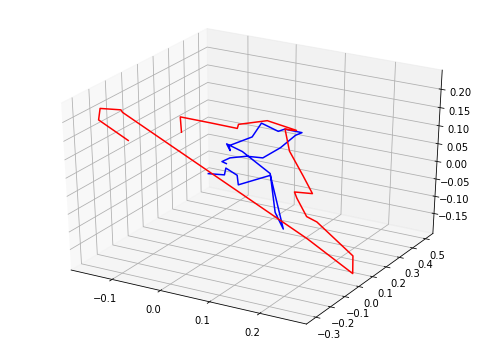

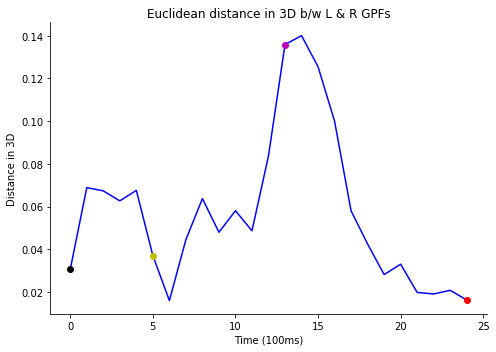

In [325]:
# Measure distance between Left and Right trials
reduced_Y_left = np.mean(reduced_Y_transform[choice_only==0,:,:],axis=0);
reduced_Y_right = np.mean(reduced_Y_transform[choice_only==1,:,:],axis=0);

f = plt.figure(figsize=(7,5)); ax2 = f.add_subplot(111, projection='3d')
ax2.plot3D(reduced_Y_left[0,:],reduced_Y_left[1,:],reduced_Y_left[2,:],'b');
ax2.plot3D(reduced_Y_right[0,:],reduced_Y_right[1,:],reduced_Y_right[2,:],'r');

# Find euclidean distance between curves
dist_left_right = (reduced_Y_left[0,:] - reduced_Y_right[0,:])**2 + (reduced_Y_left[1,:] - reduced_Y_right[1,:])**2 +(reduced_Y_left[2,:] - reduced_Y_right[2,:])**2
startidx = 0; stim_onset = 5; go_cue = 13; end_idx = 24;

f=plt.figure(figsize=(7,5));
plt.plot(dist_left_right,'b'); plt.title('Euclidean distance in 3D b/w L & R GPFs');plt.xlabel('Time (100ms)'); plt.ylabel('Distance in 3D');
plt.plot(startidx, dist_left_right[startidx],'ok'); plt.plot(stim_onset,dist_left_right[stim_onset],'oy');
plt.plot(go_cue,dist_left_right[go_cue],'om'); plt.plot(end_idx,dist_left_right[end_idx],'or');
plt.savefig('GPFA distance.png');
plt.show()

In [258]:
# Evaluate decoding accuracy:

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_validate 
from sklearn.linear_model import LogisticRegression

nb_clf = BernoulliNB()
scores = cross_validate(nb_clf, reduced_Y_reshape, choice_only, cv=3, return_train_score=True)

print(scores)
score = np.mean(scores['test_score'])
print(score);
print(np.std(scores['test_score']))

lr_clf = LogisticRegression(random_state=0)
scores2 = cross_validate(lr_clf, reduced_Y_reshape, choice_only, cv=3, return_train_score=True);
score2= np.mean(scores2['test_score']);
print(scores2)
print(np.std(scores2['test_score']))
# print(f'{score2:d} +/- {np.std(scores2['test_score']):d}')

{'fit_time': array([0.07432699, 0.08655596, 0.20201087]), 'score_time': array([0.02709699, 0.02185392, 0.06013417]), 'test_score': array([0.55150934, 0.5       , 0.50359712]), 'train_score': array([0.57564133, 0.59180249, 0.6005272 ])}
0.5183688219525003
0.023479855923685112


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'fit_time': array([2.80998206, 0.97477198, 1.7907598 ]), 'score_time': array([0.01054597, 0.00907016, 0.01689816]), 'test_score': array([0.52515573, 0.49376798, 0.52997602]), 'train_score': array([0.66195157, 0.67138063, 0.67577283])}
0.016053550420112507


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


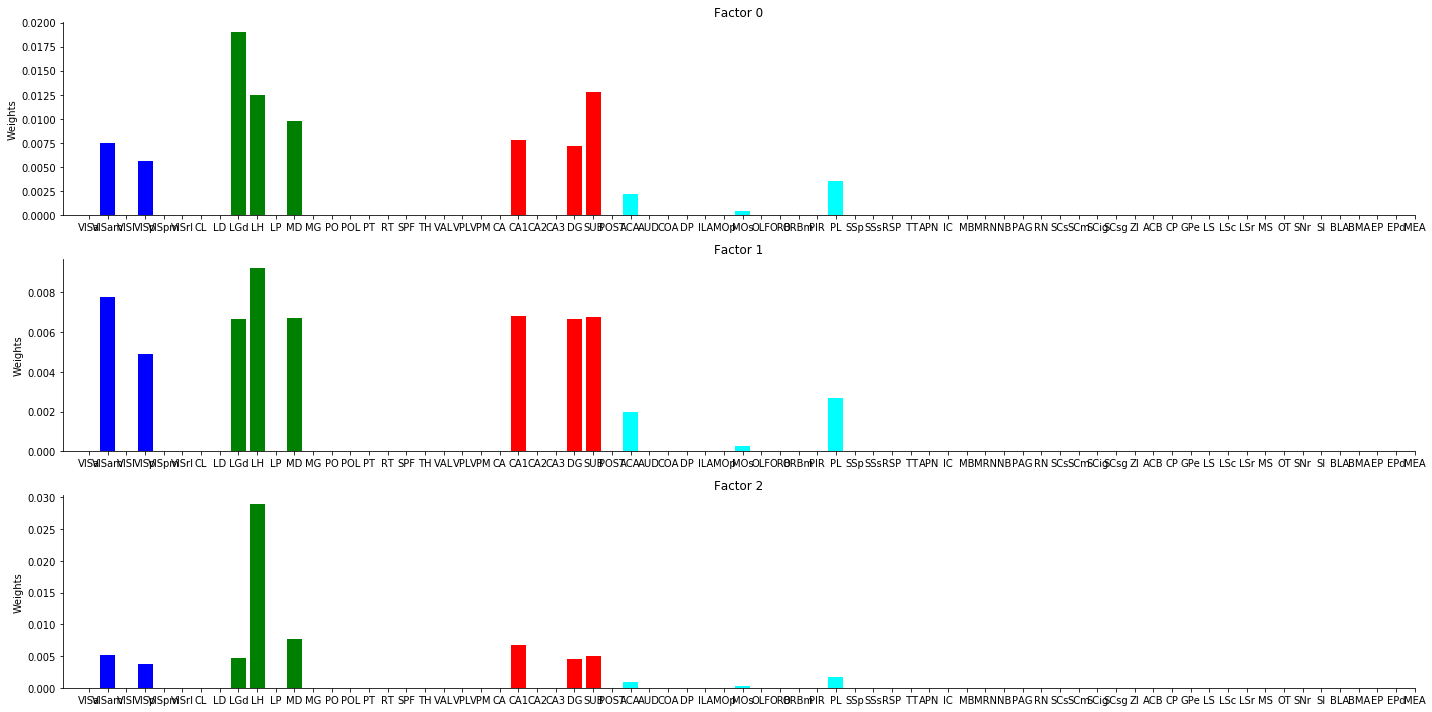

In [404]:

regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = len(regions)-1 # only the top 4 regions are in this particular mouse (/session(TR?))
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each regi

all_brain_groups = []; all_area = [];
for sublist in range(len(brain_groups)):
    for item in range(len(brain_groups[sublist])):
        all_brain_groups.append(brain_groups[sublist][item])
        all_area.append(sublist);

        
col_list = ['blue','green','red','cyan','magenta','yellow','black']
which_color=1;
f = plt.figure(figsize=(20,10));
for ifa in range(3):
    for ib in range(len(all_brain_groups)):
        which_color=all_area[ib]
        plt.subplot(3,1,ifa+1); 
        plt.bar(ib, np.mean(np.abs(C[dat['brain_area'][:-1] == all_brain_groups[ib],ifa])),color=col_list[which_color])
        plt.xticks(range(len(all_brain_groups)),all_brain_groups);
        plt.title(f"Factor {ifa:d}"); plt.ylabel('Weights');
        
plt.savefig('GPFA weights');
plt.show();


In [419]:
# Try GPFA one more time here:
from elephant.gpfa import GPFA
import quantities as pq
from neo.core import SpikeTrain
import pdb

Y=np.transpose(dat['spks'],(1,0,2));
gpfa = GPFA(bin_size=10*pq.ms, x_dim=8)

n_trial=340; n_neuron=698;
l2=np.empty(shape=(n_trial,n_neuron),dtype='object');
for e1 in range(n_trial):
  for e2 in range(n_neuron):
    xx=np.array(np.where((Y[e1][e2]) == 1))[0];
    if len(xx) == 0:
      xx=np.array([0])
    l2[e1][e2] = SpikeTrain(xx*pq.ms, t_stop=2500); #Get time of spike train

 


In [420]:
gpfa.fit(l2.tolist());
print('done')

Initializing parameters using factor analysis...

Fitting GPFA model...


KeyboardInterrupt: 

/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


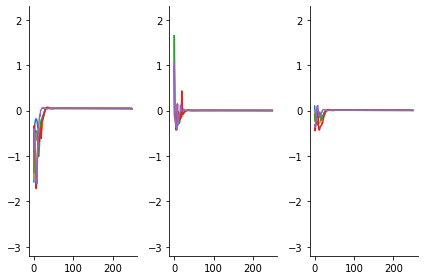

In [418]:
trajectories = gpfa.transform(l2.tolist());
for it in range(5):
    plt.subplot(1,3,1); plt.plot(trajectories[it][0,:]); plt.ylim([-3.2,2.3])
    plt.subplot(1,3,2); plt.plot(trajectories[it][1,:]); plt.ylim([-3.2,2.3])
    plt.subplot(1,3,3); plt.plot(trajectories[it][2,:]); plt.ylim([-3.2,2.3])
    
plt.show()

### Continue with plots

In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

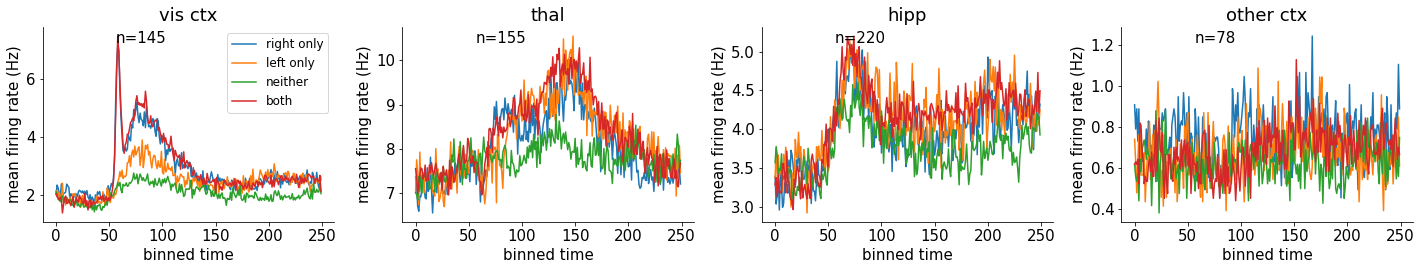

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


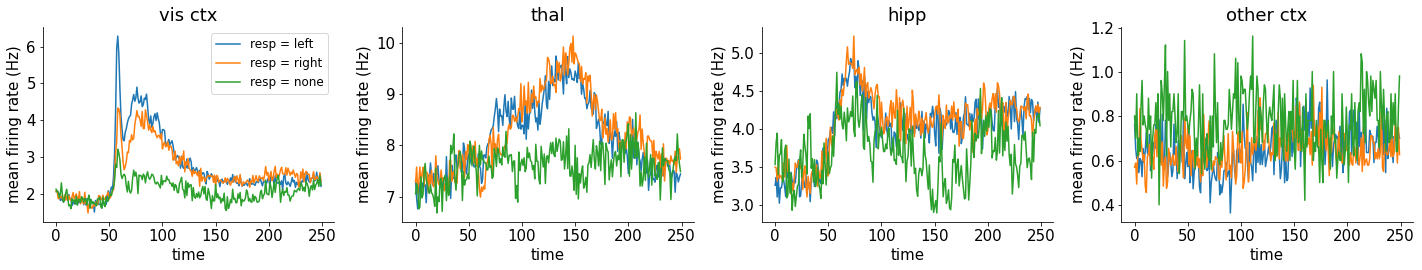

In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

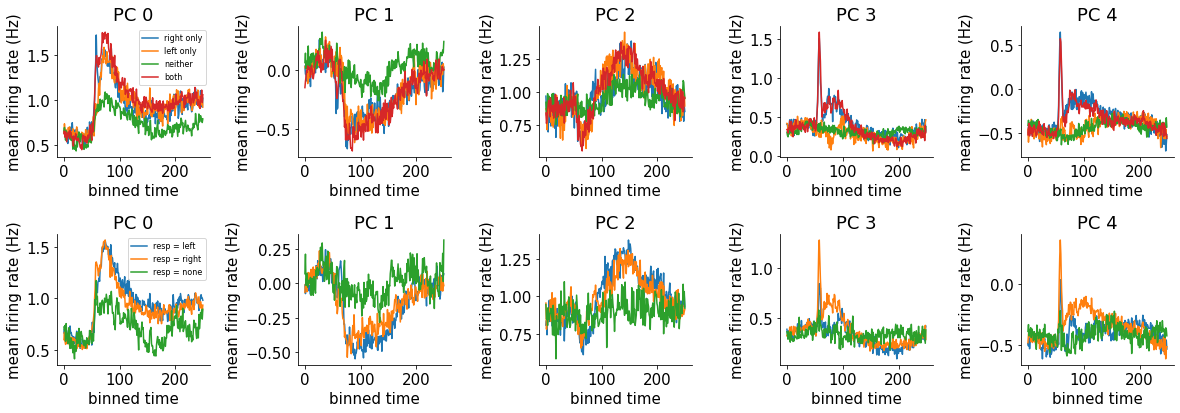

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

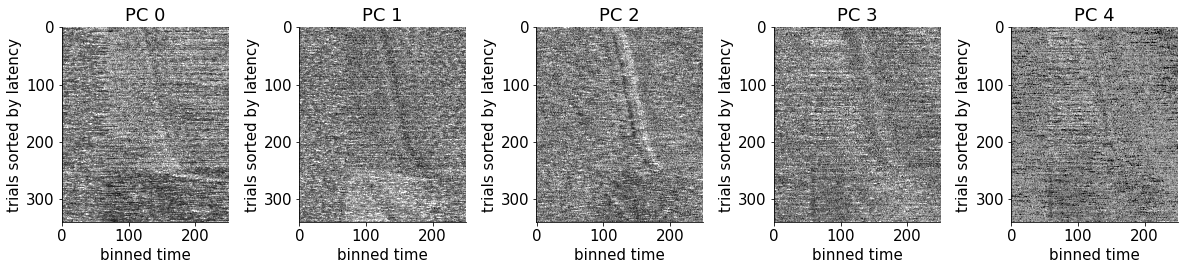

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

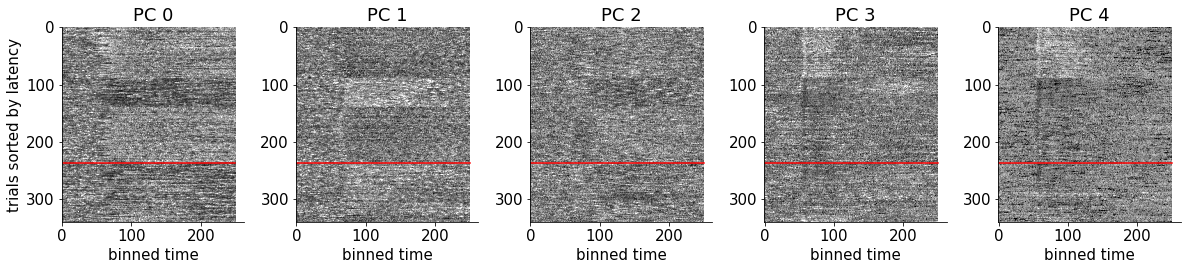

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


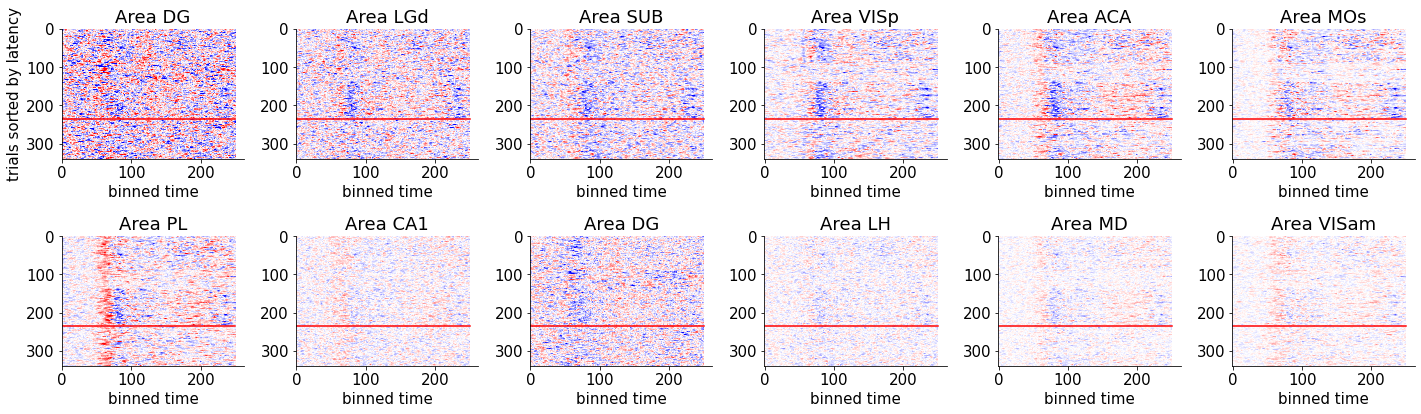

In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


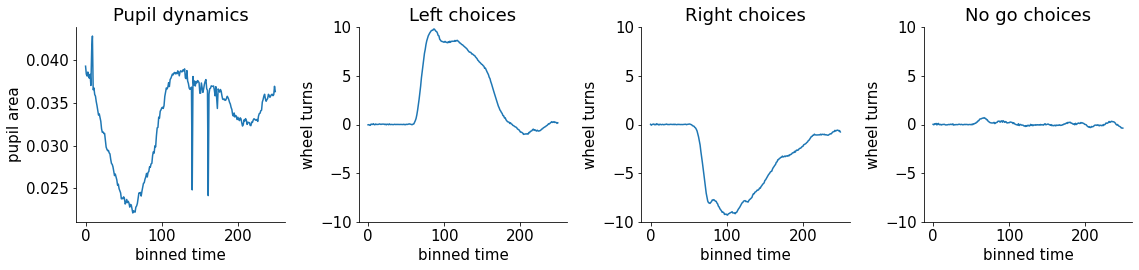

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


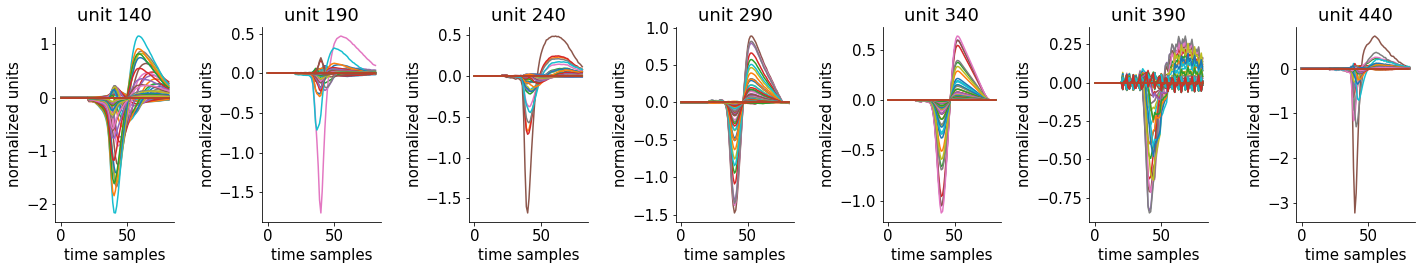

In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

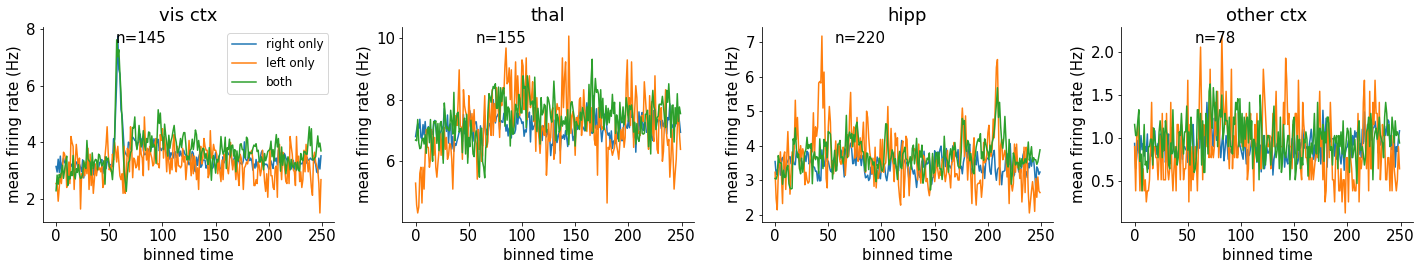

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')